<a href="https://colab.research.google.com/github/leesurkis/Sentinel/blob/master/2_FakeNewsClassifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sentinel Take Home - Fake News Classifier 

## 1. **EDA**

In [4]:
#Importing all the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from wordcloud import WordCloud
import os
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
fake = pd.read_json('fake_test.json')
real = pd.read_json('real_test.json')

In [86]:
print(fake.shape) 
fake.sample(5)

(200, 3)


,url,title,text
26,https://libya24.tv/libya-in-media/278997,America is still the first suspect .. New fact...,America is still the first suspect .. New fact...
138,http://www.aqsasport.org/sport/index.php/news/...,"Amir Khan: Corona Virus Linked to ""5G"" Network...","The British boxer, Amir Khan, believes that th..."
47,http://www.znn-lb.com/archives/369895,A famous Russian doctor reveals the secret of ...,"Elena Malysheva, the famous Russian presenter ..."
28,https://qazweek.kz/ru/2020/04/06/%D0%B2-%D1%81...,Covid-19 creator for China arrested in US,"In February, the famous Harvard biologist Char..."
78,https://www.eldjazaireldjadida.com/%D8%B7%D8%A...,A famous doctor reveals the secret of immunity...,A famous doctor reveals the secret of immunity...


In [88]:
print(real.shape) 
real.sample(5)

(200, 3)


,url,title,text
122,https://www.wsj.com/articles/congress-can-take...,Congress Can Take the Economic Edge off Covid ...,- Opinion\n- Commentary\nCongress Can Take the...
27,https://www.theatlantic.com/international/arch...,Coronavirus Is Devastating Chinese Tourism,"Thant Zin Tun, a hotel owner with properties a..."
134,https://www.euronews.com/living/2020/03/24/gre...,Greta Thunberg sets an example by self - isola...,Climate activist Greta Thunberg has released a...
140,https://www.themoscowtimes.com/2020/03/16/mosc...,Moscow Coronavirus Patient Escapes Hospital Qu...,A Russian patient has escaped from coronavirus...
8,https://www.nytimes.com/2020/04/03/business/co...,Corona Beer to Halt Production Amid Coronaviru...,Corona beer has become a temporary victim of t...


In [89]:
def print_full(x):
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [90]:
print_full(real.sample())

                                                                                                                     url  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [91]:
print_full(fake.sample())

                                                            url  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

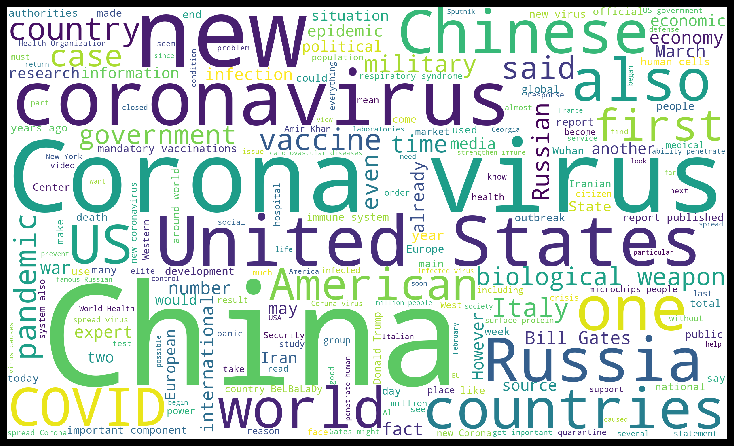

In [92]:
txt = fake.text.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1500, background_color='white', 
                     stopwords = set(nltk.corpus.stopwords.words("english"))).generate(txt)
fig = plt.figure(figsize=(10, 15), facecolor='k', edgecolor=None)
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del txt

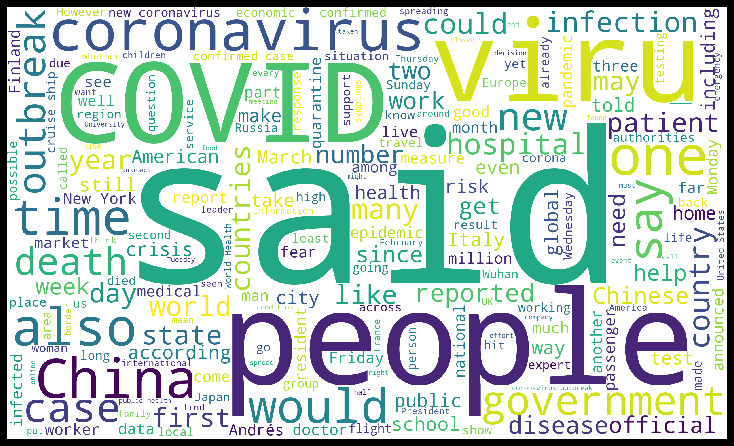

In [93]:
txt = real.text.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1500, background_color='white', 
                     stopwords = set(nltk.corpus.stopwords.words("english"))).generate(txt)
fig = plt.figure(figsize=(10, 15), facecolor='k', edgecolor=None)
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del txt

In [94]:
# counting number of words in each article per dataset 
fake['words_count'] = fake['text'].str.split().str.len()
real['words_count'] = real['text'].str.split().str.len()

In [95]:
fake.sample()

,url,title,text,words_count
149,https://sada-ar.com/world/article-596884/%D8%A...,Russian experts think Corona will fall from a ...,"Vyacheslav Eileen, head of the department of t...",483


In [96]:
fake.words_count.describe()

count     200.000000
mean      466.660000
std       559.036693
min        11.000000
25%       197.000000
50%       250.000000
75%       507.000000
max      4435.000000
Name: words_count, dtype: float64

In [97]:
real.words_count.describe()

count     200.000000
mean      552.290000
std       574.173293
min        25.000000
25%       246.000000
50%       402.000000
75%       660.250000
max      4774.000000
Name: words_count, dtype: float64

In [98]:
# taking a closer look at the highest word count to see if it's an outlier
fake.url[fake['words_count']==23930]

# the article is another language which we aren't working with, so it will be removed
fake = fake[fake.words_count != 23930]

# checking new distribution
fake.words_count.describe()

count     200.000000
mean      466.660000
std       559.036693
min        11.000000
25%       197.000000
50%       250.000000
75%       507.000000
max      4435.000000
Name: words_count, dtype: float64

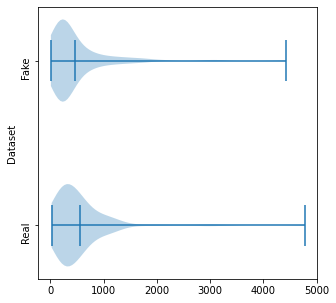

In [99]:
# visualising distribution of article length using a Violin plot
fig, ax = plt.subplots(figsize=(5,5))
ax.violinplot([fake.words_count, real.words_count][::-1],positions =[1, 2],vert=False,showmeans=True)

labels = ['Fake', 'Real'][::-1]
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, rotation='vertical')
ax.set_ylabel('Dataset');

## 2. **Pre-processing**

In [155]:
# copy dfs in order to not overwrite
fake_preprocess = fake.copy()
real_preprocess = real.copy()

# create new col with repeated title in 'text' column removed. This is done by replacing the string from the title col with nothing, if it is repeated in the text col
fake_preprocess['text_no_title'] = fake_preprocess.text.replace(fake_preprocess.title[fake_preprocess.title.notnull()], '', regex = True).str.strip()
real_preprocess['text_no_title'] = real_preprocess.text.replace(real_preprocess.title[real_preprocess.title.notnull()], '', regex = True).str.strip()

# update words_count
fake_preprocess['words_count_no_title'] = fake_preprocess['text_no_title'].str.split().str.len()
real_preprocess['words_count_no_title'] = real_preprocess['text_no_title'].str.split().str.len()

fake_preprocess.sample(5)

,url,title,text,words_count,text_no_title,words_count_no_title
72,https://www.m24.ru/videos/obshchestvo/27022020...,Jackie Chan quarantined due to possible corona...,"Jackie Chan was quarantined. The famous actor,...",97,"Jackie Chan was quarantined. The famous actor,...",97
117,https://www.yemenipress.net/archives/185027,An important statement of global health regard...,An important statement of global health regard...,178,676\nShare\nYemeni Press - Follow-up\nThe Worl...,152
137,https://mundo.sputniknews.com/firmas/202003121...,A coronavirus to hack the world system,The academic argued that in the face of a scen...,1795,The academic argued that in the face of a scen...,1795
52,https://www.rt.com/shows/crosstalk/484243-pand...,"CrossTalk, QUARANTINE EDITION: Rights vs Security",As governments all over the world enact and en...,37,As governments all over the world enact and en...,37
172,https://pikabu.ru/story/v_ssha_arestovan_sozda...,Covid-19 creator for China arrested in US,The Trump administration and the US Congress a...,376,The Trump administration and the US Congress a...,376


In [156]:
# drop columns we don't need 
fake_preprocess.drop(columns=['text', 'words_count'], inplace=True)
real_preprocess.drop(columns=['text', 'words_count'], inplace=True)

In [157]:
real_preprocess['class'] = 0
fake_preprocess['class'] = 1

combined_data = real_preprocess.append(fake_preprocess, ignore_index=True)
del real_preprocess, fake_preprocess

In [158]:
# defining our input variable, reformatting from df to numpy array removing punctuation and stop words
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in combined_data["text_no_title"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [159]:
# defining target variable
y = combined_data['class']

## 3. **Model Development**

In [160]:
import gensim

Word embeddings are vector representations of words, they are used to understand the semantic relationship between words. 

Word2Vec is a pretrained algorithm in word embeddings so it understands the contect of words and can save time when training a model. 

In [161]:
# setting the dimension
EMBEDDING_DIM = 100
# creating word vectors using Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

# we can check the vector for a chosen word in our dataset, e.g. COVID
w2v_model['covid']

array([-8.8217998e-01, -7.2977847e-01, -4.9016547e-01,  3.8959596e-01,
       -3.2524025e-01,  8.2320720e-02,  9.5221263e-01, -9.2696953e-01,
       -1.6535732e+00,  1.6009384e-01,  2.8703186e-01,  8.9960271e-01,
        6.8248290e-01, -5.0750399e-01,  1.5247703e-01, -1.2351268e-01,
       -8.1214262e-03, -6.2461233e-01, -6.8098116e-01,  1.0380120e+00,
       -9.4071746e-01,  1.8720031e-01, -3.3584511e-01,  3.5499731e-01,
        1.5243916e-01, -5.3111255e-01,  1.1831854e-01,  1.0723793e-01,
        1.5665550e+00, -6.0195953e-01,  5.8520555e-01,  6.4219527e-02,
        2.7033663e-01,  3.2376063e-01,  2.3633981e-01, -7.1310091e-01,
        2.9573402e-01, -1.3711229e-01,  1.7097941e-02,  4.5442683e-01,
       -9.8491895e-01, -1.0907919e+00, -3.3255887e-01, -7.7450001e-01,
        7.6483762e-01,  2.8947613e-01,  3.4293037e-02, -1.8048309e-01,
        1.7348118e+00, -2.4452199e-01, -4.7777179e-01, -1.1035249e-02,
       -7.0296609e-01,  1.4938377e-01,  4.6649483e-01, -1.5114427e-02,
      

In [162]:
# we need to tokanize the words to numerical representations for the embedding layer of the Neural Network
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [163]:
# reviewing some word to numerical representations
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

virus -> 1
coronavirus -> 2
people -> 3
said -> 4
china -> 5
new -> 6
19 -> 7
covid -> 8
health -> 9
world -> 10


In [164]:
# creating the weights for the model
def get_weight_matrix(model, vocab):
    # total vocab size + 0 for unknown words
    vocab_size = len(vocab)+1
    #inetialize weight matrix with all zeros
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix
  
embedding_vectors = get_weight_matrix(w2v_model, word_index)


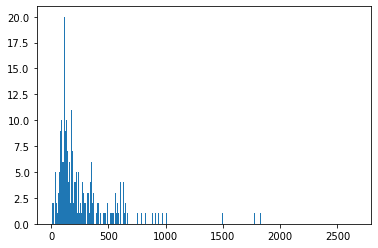

In [165]:
# defining the max length of an article

plt.hist([len(x) for x in X], bins=500)
plt.show()

# it looks like the vast majority are under 1000 words

In [137]:
# # check that 1000 gives a good distribution

# wordcount = np.array([len(x) for x in X])
# print('total articles: ', len(X))
# print('articles with less than 1000 words: ', len(wordcount[wordcount  < 1000]))

In [167]:
# setting to 1000 with padding

maxlen = 1000
X = pad_sequences(X, maxlen = maxlen)

In [168]:
vocab_size = len(tokenizer.word_index) + 1

In [169]:

# creating layers for neural network model# creatin 
model = Sequential()
#adding a non-trainable embedding layer as input layer
model.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2913900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,031,277
Trainable params: 117,377
Non-trainable params: 2,913,900
_________________________________________________________________


In [170]:
X_test = np.array(X)
y_test = y

In [171]:
type(X_test)

numpy.ndarray

In [175]:
# model fit on train data in previous notebook
# model.fit(X_train, y_train, validation_split=0.3, epochs=6)


In [173]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")


In [174]:
accuracy_score(y_test, y_pred)

0.5

As we are predicting a binary classification (fake/real news), an accuracy score of  0.5 suggests that the model is completely guessing each prediction. There is obviously a lot of work that needs to be done in terms of pre-processing and hyperparameter tuning of the neural network in order to be able to make more accurate predictions.

After doing this I would also look at precision and recall.